# Install Data

- Reference Dataset:
[IAM Dataset](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database)



In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip 
!unzip -qq IAM_Words.zip 

!mkdir data 
!mkdir data/words 
!tar -xf IAM_Words/words.tgz -C data/words 
!mv IAM_Words/words.txt data

- The words.txt file contains our labels, and other information about the images

In [1]:
!head -18 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#


# Imports

In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report
import optuna

np.random.seed(42)
tf.random.set_seed(42)
# hiding tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Data Splitting

- We also remove any images that are labeled "err"
- 80/10/10 split for training, validation, test

In [3]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

np.random.shuffle(words_list)

split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

# make sure they all add up
assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


# Data Preprocessing
- Cleaning the data label that came from the words.txt file
- Building the vocabulary of characters (from training data only)

In [4]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

"""
Then we prepare the ground-truth labels.
"""

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

### Training and Test Datasets label cleaning

In [5]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Character Encoding - function definition

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Metal device set to: Apple M2


### Image Resize without Distortion

In [7]:
def distortion_free_resize(image, img_size):
    """
    * Aspect ratio is preserved.
    * Content of the images is not affected.
    """
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Final Image Preprocessing Pipeline

In [8]:
batch_size  = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

### Running All Data through Preprocessing Steps

In [106]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])
    
print(validation_labels)
print(validation_labels_cleaned)

[<tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[53, 54, 64, ..., 99, 99, 99],
       [58, 73, 64, ..., 99, 99, 99],
       [12, 99, 99, ..., 99, 99, 99],
       ...,
       [70, 57, 59, ..., 99, 99, 99],
       [72, 67, 64, ..., 99, 99, 99],
       [10, 99, 99, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[58, 61, 66, ..., 99, 99, 99],
       [53, 66, 99, ..., 99, 99, 99],
       [34, 61, 71, ..., 99, 99, 99],
       ...,
       [71, 72, 70, ..., 99, 99, 99],
       [25, 99, 99, ..., 99, 99, 99],
       [54, 53, 55, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[71, 67, 99, ..., 99, 99, 99],
       [60, 61, 71, ..., 99, 99, 99],
       [67, 58, 99, ..., 99, 99, 99],
       ...,
       [75, 61, 58, ..., 99, 99, 99],
       [12, 99, 99, ..., 99, 99, 99],
       [72, 61, 56, ..., 99, 99, 99]])>, <tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[72, 60, 70, ..., 99, 99, 99],
       [57, 58, 58, ..., 99, 99, 99],
  

# Modeling

### Optuna Hyperparmeter Tuning

In [10]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def create_model(trial):
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    conv1_activation = trial.suggest_categorical("conv1_activation", ["relu", "tanh"])
    conv1_kernal_size = trial.suggest_int("conv1_kernal_size", 2, 4, step=1) 
    conv1_filters = trial.suggest_categorical("conv1_filters", [16, 32, 64, 128])
    x = keras.layers.Conv2D(
        conv1_filters,
        (conv1_kernal_size, conv1_kernal_size),
        activation=conv1_activation,
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    #max_pooling1 = trial.suggest_int("max_pooling1", 1, 3, step=1)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    conv2_activation = trial.suggest_categorical("conv2_activation", ["relu", "tanh"])
    conv2_filters = trial.suggest_categorical("conv1_filters", [16, 32, 64, 128])
    conv2_kernal_size = trial.suggest_int("conv2_kernal_size", 2, 4)
    x = keras.layers.Conv2D(
        conv2_filters,
        (conv2_kernal_size, conv2_kernal_size),
        activation=conv2_activation,
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    #max_pooling2 = trial.suggest_int("max_pooling2", 1, 3, step=1)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    new_shape = ((image_width // 4), (image_height // 4) * conv2_filters)
    
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    # Dense 1
    dense1_activation = trial.suggest_categorical("dense1_activation", ["relu", "tanh"])
    dense1_filters = trial.suggest_categorical("dense1_filters", [16, 32, 64, 128])
    x = keras.layers.Dense(dense1_filters, 
                           activation=dense1_activation, 
                           name="dense1")(x)
    dropout = trial.suggest_float("dropout", 0.15, 0.3, step=0.05)
    x = keras.layers.Dropout(dropout)(x)

    # RNNs.
    
    dropout1 = trial.suggest_float("dropout1", 0.15, 0.3, step=0.05)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=dropout1)
    )(x)
    
    dropout2 = trial.suggest_float("dropout2", 0.15, 0.3, step=0.05)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=dropout2)
    )(x)
    
    dropout3 = trial.suggest_float("dropout3", 0.15, 0.3)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(32, return_sequences=True, dropout=dropout3)
    )(x)
    

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, 
        activation="softmax", 
        name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    
    optimizer = create_optimizer(trial)
    model.compile(optimizer=optimizer)
    
    return model

### Optuna Optimizer Hyperparameter

In [11]:
def create_optimizer(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "Adam", "SGD"])
    if optimizer_name == "RMSprop":
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        return keras.optimizers.RMSprop(learning_rate=lrn_rate)
    elif optimizer_name == "Adam":
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        return keras.optimizers.Adam(learning_rate=lrn_rate)
    else:
        lrn_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        momentum = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)
        return keras.optimizers.SGD(learning_rate=lrn_rate, momentum=momentum)

### Running the Optuna Experiment

In [ ]:
EPOCHS = 3
TRIALS = 3

def objective(trial):
    model = create_model(trial)
    model.fit(train_ds,
              validation_data=validation_ds,
              epochs=EPOCHS)
    score = model.evaluate(validation_ds, verbose=0)
    print(score)
    return score # loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=TRIALS)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-15 17:15:58,986] A new study created in memory with name: no-name-22581f33-49a2-4214-a057-4175040b3630


Epoch 1/3
1206/1206 [==============================] - 510s 419ms/step - loss: 29.8901 - val_loss: 16.6935
Epoch 2/3
1206/1206 [==============================] - 515s 427ms/step - loss: 16.0475 - val_loss: 15.8722
Epoch 3/3
1206/1206 [==============================] - 505s 419ms/step - loss: 15.4373 - val_loss: 15.1766


[I 2022-11-15 17:42:21,213] Trial 0 finished with value: 15.176605224609375 and parameters: {'conv1_activation': 'tanh', 'conv1_kernal_size': 2, 'conv1_filters': 32, 'conv2_activation': 'relu', 'conv2_kernal_size': 2, 'dense1_activation': 'tanh', 'dense1_filters': 64, 'dropout': 0.1, 'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'dropout3': 0.20925242907726854, 'optimizer': 'Adam', 'learning_rate': 3.0085399328221522e-05}. Best is trial 0 with value: 15.176605224609375.


15.176605224609375
Epoch 1/3
1206/1206 [==============================] - 511s 420ms/step - loss: 14.5179 - val_loss: 13.8301
Epoch 2/3
1206/1206 [==============================] - 486s 403ms/step - loss: 13.5051 - val_loss: 13.6879
Epoch 3/3
1206/1206 [==============================] - 494s 409ms/step - loss: 13.4111 - val_loss: 13.6284


[I 2022-11-15 18:08:02,674] Trial 1 finished with value: 13.628438949584961 and parameters: {'conv1_activation': 'tanh', 'conv1_kernal_size': 4, 'conv1_filters': 64, 'conv2_activation': 'relu', 'conv2_kernal_size': 2, 'dense1_activation': 'tanh', 'dense1_filters': 64, 'dropout': 0.1, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.28767643271258025, 'optimizer': 'Adam', 'learning_rate': 0.005330460802127013}. Best is trial 1 with value: 13.628438949584961.


13.628438949584961
Epoch 1/3


# Model Construction using Tuned Parameters

### Edit Distance Callback

In [10]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [22]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        filters=32,
        strides=(1,1),
        kernel_size=(2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(2, 2),
        strides=(1,1), 
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(200, return_sequences=True, dropout=0.20)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.20)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.20)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer
                 )
    
    return model

# Model Training

In [92]:
epochs = 35

model = build_model()
model.summary()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, 
    model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)


# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback]
)

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  160         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   8256        ['pool1[0][0

1/1 [==============================] - 0s 78ms/step
Mean edit distance for epoch 2: 20.1485
1357/1357 [==============================] - 555s 409ms/step - loss: 10.4441 - val_loss: 10.1528
Epoch 3/35
1/1 [==============================] - 0s 98ms/step
Mean edit distance for epoch 3: 19.4991
1357/1357 [==============================] - 552s 406ms/step - loss: 8.2292 - val_loss: 7.7496
Epoch 4/35
2/2 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 88ms/step
Mean edit distance for epoch 4: 18.6727
1357/1357 [==============================] - 553s 408ms/step - loss: 6.1067 - val_loss: 5.4397
Epoch 5/35
1/1 [==============================] - 0s 126ms/step
Mean edit distance for epoch 5: 18.3255
1357/1357 [==============================] - 565s 416ms/step - loss: 4.6756 - val_loss: 4.5411
Epoch 6/35
2/2 [==============================] - 0s 32ms/steps - loss: 3.80


1/1 [==============================] - 0s 78ms/step
Mean edit distance for epoch 6: 18.1130
1357/1357 [==============================] - 564s 415ms/step - loss: 3.8032 - val_loss: 3.9267
Epoch 7/35
1/1 [==============================] - 0s 86ms/step
Mean edit distance for epoch 7: 18.1257
1357/1357 [==============================] - 570s 420ms/step - loss: 3.2198 - val_loss: 4.0233
Epoch 8/35


1/1 [==============================] - 0s 76ms/step
Mean edit distance for epoch 8: 18.2559
1357/1357 [==============================] - 567s 418ms/step - loss: 2.7607 - val_loss: 4.6535
Epoch 9/35
1/1 [==============================] - 0s 78ms/step
Mean edit distance for epoch 9: 17.8747
1357/1357 [==============================] - 2392s 2s/step - loss: 2.4210 - val_loss: 3.4531


Epoch 10/35
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 10: 17.7130
1357/1357 [==============================] - 2085s 2s/step - loss: 2.1829 - val_loss: 3.0971
Epoch 11/35
1/1 [==============================] - 0s 66ms/step
Mean edit distance for epoch 11: 17.7167
1357/1357 [==============================] - 2042s 2s/step - loss: 1.9393 - val_loss: 3.1113


Epoch 12/35
1/1 [==============================] - 0s 70ms/step
Mean edit distance for epoch 12: 17.7452
1357/1357 [==============================] - 10413s 8s/step - loss: 1.7065 - val_loss: 3.2945
Epoch 13/35
1/1 [==============================] - 0s 55ms/step
Mean edit distance for epoch 13: 17.7266
1357/1357 [==============================] - 15128s 11s/step - loss: 1.5500 - val_loss: 3.3834


Epoch 14/35
1/1 [==============================] - 0s 55ms/step
Mean edit distance for epoch 14: 17.7306
1357/1357 [==============================] - 48252s 36s/step - loss: 1.3895 - val_loss: 3.5777
Epoch 15/35
1/1 [==============================] - 0s 57ms/step
Mean edit distance for epoch 15: 17.7957
1357/1357 [==============================] - 24342s 18s/step - loss: 1.2447 - val_loss: 3.9041


Epoch 16/35
1/1 [==============================] - 0s 60ms/step
Mean edit distance for epoch 16: 17.8100
1357/1357 [==============================] - 26715s 20s/step - loss: 1.1075 - val_loss: 4.0797
Epoch 17/35
1/1 [==============================] - 0s 73ms/step
Mean edit distance for epoch 17: 17.8993
1357/1357 [==============================] - 1870s 1s/step - loss: 1.0323 - val_loss: 4.5386


Epoch 18/35
1/1 [==============================] - 0s 67ms/step
Mean edit distance for epoch 18: 17.7654
1357/1357 [==============================] - 569s 419ms/step - loss: 0.9765 - val_loss: 4.0622
Epoch 19/35
1/1 [==============================] - 0s 64ms/step
Mean edit distance for epoch 19: 17.7316
1357/1357 [==============================] - 565s 417ms/step - loss: 0.8699 - val_loss: 4.0325


Epoch 20/35
1/1 [==============================] - 0s 61ms/step
Mean edit distance for epoch 20: 17.7086
1357/1357 [==============================] - 569s 420ms/step - loss: 0.7844 - val_loss: 4.0048
Epoch 21/35
1/1 [==============================] - 0s 66ms/step
Mean edit distance for epoch 21: 17.6991
1357/1357 [==============================] - 573s 422ms/step - loss: 0.7350 - val_loss: 4.0898


Epoch 22/35
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 22: 17.6773
1357/1357 [==============================] - 563s 415ms/step - loss: 0.7250 - val_loss: 3.9953
Epoch 23/35
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 23: 17.7024
1357/1357 [==============================] - 559s 412ms/step - loss: 0.6504 - val_loss: 4.1946


Epoch 24/35
1/1 [==============================] - 0s 55ms/step
Mean edit distance for epoch 24: 17.7113
1357/1357 [==============================] - 560s 412ms/step - loss: 0.6378 - val_loss: 4.2856
Epoch 25/35
1/1 [==============================] - 0s 70ms/step
Mean edit distance for epoch 25: 17.6860
1357/1357 [==============================] - 670s 494ms/step - loss: 0.5760 - val_loss: 4.3802


Epoch 26/35
1/1 [==============================] - 0s 89ms/step
Mean edit distance for epoch 26: 17.6739
1357/1357 [==============================] - 583s 430ms/step - loss: 0.5465 - val_loss: 4.3369
Epoch 27/35
1/1 [==============================] - 0s 114ms/step
Mean edit distance for epoch 27: 17.6762
1357/1357 [==============================] - 765s 564ms/step - loss: 0.5157 - val_loss: 4.3822


Epoch 28/35
1/1 [==============================] - 0s 102ms/step
Mean edit distance for epoch 28: 17.6710
1357/1357 [==============================] - 670s 494ms/step - loss: 0.4948 - val_loss: 4.3816
Epoch 29/35
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 29: 17.6596
1357/1357 [==============================] - 595s 438ms/step - loss: 0.4714 - val_loss: 4.4353


Epoch 30/35
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 30: 17.6381
1357/1357 [==============================] - 557s 411ms/step - loss: 0.4619 - val_loss: 4.4097
Epoch 31/35
1/1 [==============================] - 0s 60ms/step
Mean edit distance for epoch 31: 17.6502
1357/1357 [==============================] - 666s 491ms/step - loss: 0.4323 - val_loss: 4.4630


Epoch 32/35
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 32: 17.6354
1357/1357 [==============================] - 579s 427ms/step - loss: 0.4312 - val_loss: 4.4785
Epoch 33/35
1/1 [==============================] - 0s 81ms/step
Mean edit distance for epoch 33: 17.6344
1357/1357 [==============================] - 651s 480ms/step - loss: 0.4139 - val_loss: 4.4865


Epoch 34/35
1/1 [==============================] - 0s 138ms/step
Mean edit distance for epoch 34: 17.6431
1357/1357 [==============================] - 794s 585ms/step - loss: 0.3997 - val_loss: 4.5568
Epoch 35/35
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 35: 17.6727
1357/1357 [==============================] - 696s 512ms/step - loss: 0.3849 - val_loss: 4.7249


In [93]:
model.evaluate(validation_ds, verbose=0)

4.724868297576904

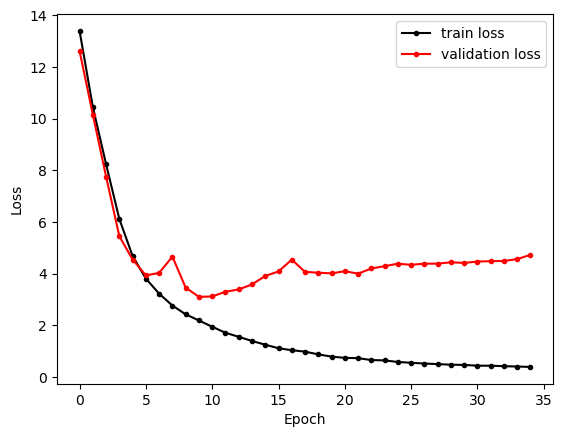

Final train loss: 0.38491091132164


In [94]:
def plot_loss(model, history):
    """Plot the loss after each training epoch."""
    history = pd.DataFrame(history.history)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

    # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])
    
plot_loss(model, history)

# Evaluation

2/2 [==============================] - 0s 39ms/step


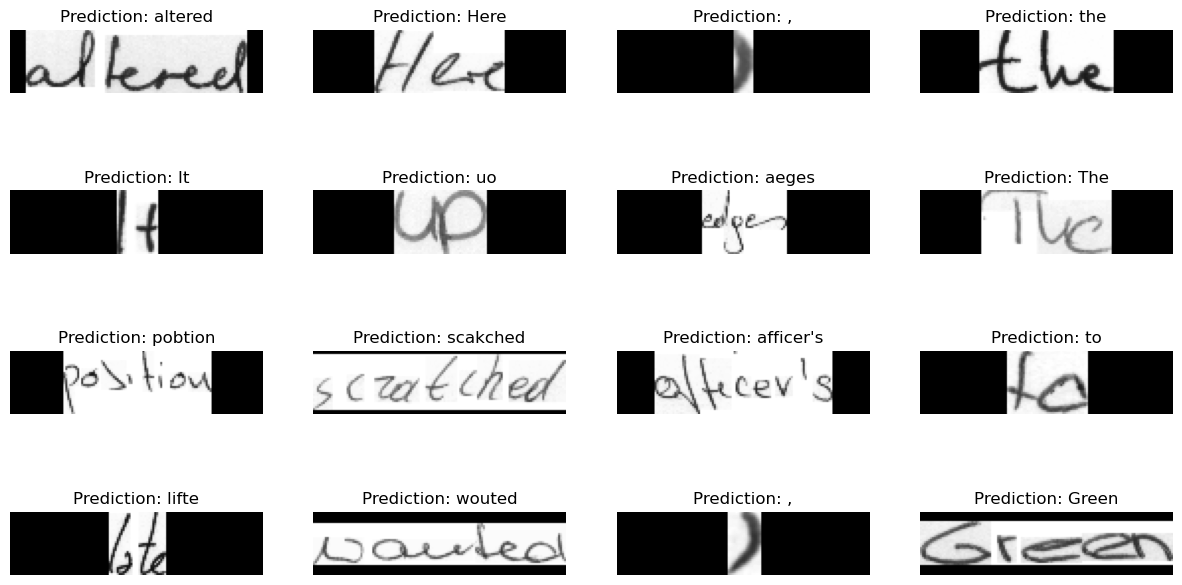

In [95]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [96]:
preds = prediction_model.predict(test_ds)
pred_texts = decode_batch_predictions(preds)
pred_texts[:20]

/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 6s 57ms/step


['altered',
 'Here',
 ',',
 'the',
 'It',
 'uo',
 'aeges',
 'The',
 'pobtion',
 'scakched',
 "afficer's",
 'to',
 'lifte',
 'wouted',
 ',',
 'Green',
 'inspiration',
 '.',
 'He',
 'irritatea']

In [97]:
print(classification_report(test_labels_cleaned, pred_texts))

                  precision    recall  f1-score   support

               !       0.71      0.45      0.56        11
               "       0.92      0.88      0.90        51
              "0       0.00      0.00      0.00         0
               #       0.00      0.00      0.00         1
            #ane       0.00      0.00      0.00         0
             #re       0.00      0.00      0.00         0
               &       0.50      1.00      0.67         1
              &e       0.00      0.00      0.00         0
               '       0.00      0.00      0.00        15
              'd       1.00      1.00      1.00         1
             'ee       0.00      0.00      0.00         0
              'm       1.00      0.25      0.40         4
             're       1.00      1.00      1.00         1
              's       0.50      0.50      0.50         2
             've       1.00      1.00      1.00         1
               (       0.33      1.00      0.50         1
             

/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

# NLP Spellchecker

In [98]:
from autocorrect import Speller

spell = Speller(lang='en')
spell_corrected_preds = [spell(label) for label in pred_texts]

print("Predictions:", pred_texts[:5])
print("Actuals:", test_labels_cleaned[:5])
print("Spell Corrected:", spell_corrected_preds[:5])

Predictions: ['altered', 'Here', ',', 'the', 'It']
Actuals: ['altered', 'Here', "'", 'the', 'It']
Spell Corrected: ['altered', 'Here', ',', 'the', 'It']


In [99]:
print(classification_report(spell_corrected_preds, test_labels_cleaned))

                  precision    recall  f1-score   support

               !       0.45      0.71      0.56         7
               "       0.88      0.92      0.90        49
              "0       0.00      0.00      0.00         1
               #       0.00      0.00      0.00         0
            #ane       0.00      0.00      0.00         1
             #re       0.00      0.00      0.00         1
               &       1.00      0.50      0.67         2
              &e       0.00      0.00      0.00         1
               '       0.00      0.00      0.00         3
              'd       1.00      1.00      1.00         1
             'ee       0.00      0.00      0.00         1
              'm       0.25      1.00      0.40         1
             're       1.00      1.00      1.00         1
              's       0.50      0.50      0.50         2
             've       1.00      1.00      1.00         1
               (       1.00      0.33      0.50         3
             

/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [100]:
results = pd.DataFrame(columns=["actual", "prediction", "corrected_predictions"])
results["actual"] = test_labels_cleaned
results["prediction"] = pred_texts
results["corrected_predictions"] = spell_corrected_preds
results["accuracy_by_word_no_spell_check"] = results["actual"] == results["prediction"]
results["accuracy_by_word_with_spell_check"] = results["actual"] == results["corrected_predictions"]

acc_word_no_spell = len(results[results["accuracy_by_word_no_spell_check"]==True])/len(results)
acc_word_with_spell = len(results[results["accuracy_by_word_with_spell_check"]==True])/len(results)

def accuracy_by_letter(pred, actual):
    max_length = max(len(pred), len(actual))
    min_length = min(len(pred), len(actual))
    
    letters_correct = 0
    
    for i in range(min_length):
        if pred[i] == actual[i]:
            letters_correct += 1
    
    return letters_correct / max_length
    
results['acc_letter_no_spell'] = results.apply(lambda x: accuracy_by_letter(x.actual, x.prediction), axis=1)
results['acc_letter_with_spell'] = results.apply(lambda x: accuracy_by_letter(x.actual, x.corrected_predictions), axis=1)

acc_letter_no_spell = results['acc_letter_no_spell'].mean()
acc_letter_with_spell = results['acc_letter_with_spell'].mean()


print(f"Accuracy by word, no spell check: {acc_word_no_spell:.4f}")
print(f"Accuracy by word, with spell check: {acc_word_with_spell:.4f}")
print(f"Accuracy by letter, no spell check: {acc_letter_no_spell:.4f}")
print(f"Accuracy by letter, with spell check: {acc_letter_with_spell:.4f}")

Accuracy by word, no spell check: 0.6255
Accuracy by word, with spell check: 0.7064
Accuracy by letter, no spell check: 0.8094
Accuracy by letter, with spell check: 0.8155


# Testing with Real Image

/var/folders/8y/pn6zc4td4gqgzdkjr1wqvzs00000gn/T/ipykernel_95294/1966073216.py:4: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  display(im.resize((80, 80), Image.NEAREST))


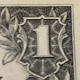

In [101]:
from PIL import Image, ImageOps

im = Image.open("dollar_bill.png")
display(im.resize((80, 80), Image.NEAREST))

/var/folders/8y/pn6zc4td4gqgzdkjr1wqvzs00000gn/T/ipykernel_95294/1125987929.py:2: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  display(im_invert.resize((80, 80), Image.NEAREST))


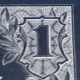

In [102]:
im_invert = ImageOps.invert(im.convert('RGB'))
display(im_invert.resize((80, 80), Image.NEAREST))
im_invert.save('inverted_dollar.jpg')

In [103]:
dollar_bill = prepare_dataset(["inverted_dollar.jpg"], ["1"])
pred = prediction_model.predict(dollar_bill)
pred_dollar_bill_label = decode_batch_predictions(pred)
pred_dollar_bill_label

1/1 [==============================] - 0s 462ms/step


['#']

1/1 [==============================] - 0s 275ms/step


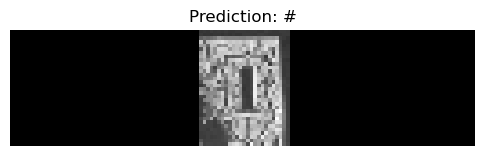

In [104]:
#  Let's check results on some test samples.
for batch in dollar_bill.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(1, 1, figsize=(6, 6))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    
    img = batch_images[0]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[0]}"
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()